In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model

import plotly.express as px # for interactive plots

#Load the Electrical Load Data

In [14]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Load"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [13]:
data = []
for y in range(2017,2023):
  df = pd.read_csv(f"{DATA_DIR}/Load_{y}.csv")
  data.append(df)
data = pd.concat(data)

NYC = data[['Time Stamp','N.Y.C.']];
NYC['Time Stamp']=pd.to_datetime(NYC['Time Stamp'])

NYCA = data[['Time Stamp','NYCA']];
NYCA['Time Stamp']=pd.to_datetime(NYCA['Time Stamp']) 

print(NYC.head(15))#;print(len(NYC.index),NYC.mean(),NYC.std())
print(NYCA.head(15))

FileNotFoundError: ignored

#Selected Dates

In [ ]:
import datetime
#heatwave = [datetime.datetime(2021,6,26,0,0,0),datetime.datetime(2021,6,29,0,0,0)]
heatwave = [datetime.datetime(2018,6,18,0,0,0),datetime.datetime(2018,6,22,0,0,0)]
coldsnap = [datetime.datetime(2017,12,26,0,0,0),datetime.datetime(2018,1,8,0,0,0)]
solar = [datetime.datetime(2021,5,5,0,0,0),datetime.datetime(2021,5,7,0,0,0)]
t_buffer = datetime.timedelta(days=7)
t_b1 = datetime.timedelta(days=1)

heatwave = [heatwave[0]-t_buffer,heatwave[1]]
coldsnap = [coldsnap[0]-t_buffer,coldsnap[1]]

t = NYC['Time Stamp']

Text(0.5, 1.0, 'Heat Wave Example \n(06/18/2018 to 06/21/2018)')

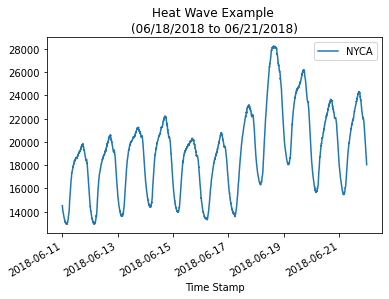

In [ ]:
m = (t >= heatwave[0]) & (t <= heatwave[1])
heatwave_df = NYCA[m].set_index('Time Stamp')
heatwave_df.plot()

start_str = (heatwave[0]+t_buffer).strftime("%m/%d/%Y")
end_str = (heatwave[1]-t_b1).strftime("%m/%d/%Y")
plt.title(f"Heat Wave Example \n({start_str} to {end_str})")

Text(0.5, 1.0, 'Cold Snap Example \n(12/26/2017 to 01/07/2018)')

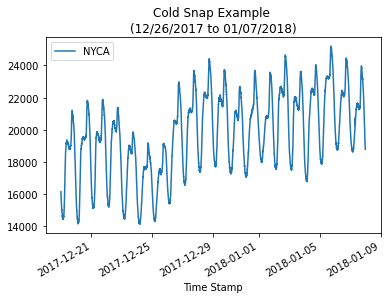

In [ ]:
m = (t >= coldsnap[0]) & (t <= coldsnap[1])
coldsnap_df = NYCA[m].set_index('Time Stamp')
coldsnap_df.plot()

start_str = (coldsnap[0]+t_buffer).strftime("%m/%d/%Y")
end_str = (coldsnap[1]-t_b1).strftime("%m/%d/%Y")
plt.title(f"Cold Snap Example \n({start_str} to {end_str})")

Text(0.5, 1.0, 'Solar Example \n(05/05/2021 to 05/06/2021)')

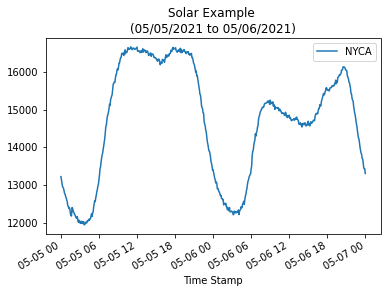

In [ ]:
m = (t >= solar[0]) & (t <= solar[1])
solar_df = NYCA[m].set_index('Time Stamp')
solar_df.plot()

start_str = (solar[0]).strftime("%m/%d/%Y")
end_str = (solar[1]-t_b1).strftime("%m/%d/%Y")
plt.title(f"Solar Example \n({start_str} to {end_str})")

# Solar Data

In [ ]:
# path to solar data in drive
SOLAR_DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Solar_Irradiance"

# iterates over each solar datasets and reads it in
solar_data = []
for y in range(2017,2021):
  df = pd.read_csv(f"{SOLAR_DATA_DIR}/solar_{y}.csv", skiprows=[0, 1])
  solar_data.append(df)

# set 2017 solar and load data
load_2017_df = pd.read_csv(f"{DATA_DIR}/Load_2017.csv")
solar_2017_df = solar_data[0]


In [ ]:
load_2017_df.head(5)

,Time Stamp,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,NYCA
0,01/01/2017 00:00:00,1211.6,1671.9,620.2,978.6,1012.3,2161.0,867.2,320.6,5116.9,539.2,1635.2,16134.7
1,01/01/2017 00:05:00,1217.2,1667.5,610.4,967.8,1008.4,2139.6,848.1,309.0,5102.1,542.5,1636.1,16048.7
2,01/01/2017 00:10:00,1210.1,1613.6,622.1,960.6,947.0,2131.8,857.2,326.9,5074.9,527.8,1630.4,15902.4
3,01/01/2017 00:15:00,1205.2,1629.4,594.4,953.4,984.6,2115.6,866.2,305.8,5089.6,531.5,1635.6,15911.3
4,01/01/2017 00:20:00,1196.2,1639.3,599.2,955.5,991.1,2110.6,848.5,305.3,5061.3,538.2,1635.1,15880.3


In [ ]:
solar_2017_df.head(5)

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,2017,1,1,0,30,4.5,0,0,0,8,...,0,75.49,121.63,0.08,1014,1.3,216,8.0,0.0,0.0
1,2017,1,1,1,30,4.6,0,0,0,8,...,0,76.35,133.00,0.08,1013,1.4,219,8.0,0.0,0.0
2,2017,1,1,2,30,4.7,0,0,0,8,...,0,77.67,144.13,0.08,1013,1.5,222,7.7,0.0,0.0
3,2017,1,1,3,30,4.7,0,0,0,8,...,0,79.29,154.28,0.08,1013,1.6,226,7.3,0.0,0.0
4,2017,1,1,4,30,4.9,0,0,0,8,...,0,79.61,161.34,0.08,1013,1.5,230,6.9,0.0,0.0


In [ ]:
# convert load time stamp to datetime object and add columns for year, month, day, hour, minute
load_2017_df['datetime'] = pd.to_datetime(load_2017_df['Time Stamp'])
load_2017_df_datetime = load_2017_df.merge(load_2017_df.datetime.apply(lambda x: pd.Series({'Year':2017, 'Month':x.month, 'Day':x.day, 'Hour':x.hour, "Minute":x.minute})), 
    left_index=True, right_index=True)
load_2017_df_datetime.head()

## Merge

### Right Merge on solar(only rows in solar exact tme match)

In [ ]:
# merge load and solar data on ['Year', 'Month', 'Day', 'Hour', 'Minute']
right_merge_df = load_2017_df_datetime.merge(solar_2017_df, how='right', left_on=['Year', 'Month', 'Day', 'Hour', 'Minute'], right_on=['Year', 'Month', 'Day', 'Hour', 'Minute'])
right_merge_df.head()

,Time Stamp,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,01/01/2017 00:30:00,1198.9,1638.7,591.4,949.4,966.4,2085.5,834.5,309.5,5011.6,...,0,75.49,121.63,0.08,1014,1.3,216,8.0,0.0,0.0
1,01/01/2017 01:30:00,1150.3,1575.6,562.9,904.1,922.7,1956.5,788.2,294.2,4861.0,...,0,76.35,133.00,0.08,1013,1.4,219,8.0,0.0,0.0
2,01/01/2017 02:30:00,1117.4,1522.2,545.4,879.0,884.2,1832.2,758.7,273.9,4648.6,...,0,77.67,144.13,0.08,1013,1.5,222,7.7,0.0,0.0
3,01/01/2017 03:30:00,1092.9,1482.7,507.7,869.7,860.9,1763.4,739.1,263.4,4517.4,...,0,79.29,154.28,0.08,1013,1.6,226,7.3,0.0,0.0
4,01/01/2017 04:30:00,1094.0,1510.3,500.4,859.8,854.0,1725.4,736.6,262.7,4429.6,...,0,79.61,161.34,0.08,1013,1.5,230,6.9,0.0,0.0


In [ ]:
print(right_merge_df.shape, solar_2017_df.shape) #16 extra observations?

(8776, 38) (8760, 24)


In [ ]:
right_merge_df.columns

Index(['Time Stamp', 'CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL',
       'LONGIL', 'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST', 'NYCA',
       'datetime', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature',
       'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'DHI', 'DNI', 'Fill Flag', 'GHI', 'Relative Humidity',
       'Solar Zenith Angle', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed',
       'Global Horizontal UV Irradiance (280-400nm)',
       'Global Horizontal UV Irradiance (295-385nm)'],
      dtype='object')

## Data Visualizations

In [ ]:
# create 3d scatter plot
fig = px.scatter_3d(right_merge_df, x='Temperature', y='Global Horizontal UV Irradiance (280-400nm)', z='NYCA',
              color='Solar Zenith Angle')

# adjust marker size to see all data points
fig.update_traces(marker_size = 2)

# adjust layout
fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)
fig.show()

In [ ]:
# create 3d scatter plot
fig = px.scatter_3d(right_merge_df, x='Temperature', y='Global Horizontal UV Irradiance (295-385nm)', z='NYCA',
              color='Solar Zenith Angle')

# adjust marker size to see all data points
fig.update_traces(marker_size = 2)

# adjust layout
fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)
fig.show()

In [ ]:
fig = px.scatter(right_merge_df, x='Temperature', y='NYCA', title='Load vs Temperature')
fig.update_layout(
    autosize=False,
    width=1000,
    height=800
)
fig.show()

In [ ]:
fig = px.scatter(right_merge_df, x='Relative Humidity', y='NYCA', title='Relative Humidity vs Load')
fig.update_layout(
    autosize=False,
    width=1000,
    height=800
)
fig.show()

In [ ]:
fig = px.scatter(right_merge_df, x='Relative Humidity', y='Global Horizontal UV Irradiance (295-385nm)', title='Humidity vs Global Horizontal Irradiance (GHI)')
fig.update_layout(
    autosize=False,
    width=1000,
    height=800
)
fig.show()

In [ ]:
fig = px.scatter(right_merge_df, x='Solar Zenith Angle', y='Global Horizontal UV Irradiance (295-385nm)', title='Solar Zenith Angle vs Global Horizontal Irradiance (GHI)')
fig.update_layout(
    autosize=False,
    width=1000,
    height=800
)
fig.show()

In [ ]:
fig = px.scatter(right_merge_df, x='GHI', y='DHI', title='GHI vs DHI')
fig.update_layout(
    autosize=False,
    width=1000,
    height=800
)
fig.show()

In [ ]:
fig = px.scatter(right_merge_df, x='Solar Zenith Angle', y='DNI', title='Solar Zenith Angle vs DNI')
fig.update_layout(
    autosize=False,
    width=1000,
    height=800
)
fig.show()

In [ ]:
fig = px.scatter(right_merge_df, x='Wind Speed', y='NYCA', title='Wind Speed vs NYCA')
fig.update_layout(
    autosize=False,
    width=1000,
    height=800
)
fig.show()